**We use normalized dataset with connection-based features**

In [ ]:
import os
from os.path import join
import glob
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def display_metrics(y_test, y_pred, label_names):
  print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

  print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
  print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
  print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

  print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
  print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
  print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

  print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
  print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
  print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

  print('\nClassification Report\n')
  print(classification_report(y_test, y_pred, target_names=label_names))

In [ ]:
def make_value2index(attacks):
    #make dictionary
    attacks = sorted(attacks)
    d = {}
    counter=0
    for attack in attacks:
        d[attack] = counter
        counter+=1
    return d

In [ ]:
# chganges label from string to integer/index
def encode_label(Y_str):
    labels_d = make_value2index(np.unique(Y_str))
    Y = [labels_d[y_str] for y_str  in Y_str]
    Y = np.array(Y)
    return np.array(Y)

## Step 1. Loading csv files

In [ ]:
# All columns
col_names = np.array(['dst sport count', 'src dport count', 'dst src count', 'dport count', 'sport count', 'dst host count','src host count','Source Port', 'Destination Port',
                      'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets',
                      'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
                      'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                      'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total',
                      'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
                      'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
                      'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
                      'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
                      'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size',
                      'Avg Bwd Segment Size','Subflow Fwd Packets', 'Subflow Fwd Bytes',
                      'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
                      'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
                      'Idle Std', 'Idle Max', 'Idle Min', 'Label'])

### Option 1. Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load three csv files generated by mlp4nids (Multi-layer perceptron for network intrusion detection )
# first load the train set
df_train = pd.read_csv('/content/drive/My Drive/CICIDS2017/train_set_ext78_2.csv',names=col_names, skiprows=1)  

In [ ]:
print('Train set size: ', df_train.shape)

Train set size:  (879589, 79)


In [ ]:
df_test = pd.read_csv('/content/drive/My Drive/CICIDS2017/test_set_ext78_2.csv',names=col_names, skiprows=1)  
print('Test set size: ', df_test.shape)

df_val = pd.read_csv('/content/drive/My Drive/CICIDS2017/crossval_set_ext78_2.csv',names=col_names, skiprows=1)  
print('Validation set size: ', df_val.shape)

Test set size:  (188483, 79)
Validation set size:  (188484, 79)


## Step 2. Exploring the dataset

In [ ]:
df_train.head()

,dst sport count,src dport count,dst src count,dport count,sport count,dst host count,src host count,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,2,100,100,100,2,100,100,61477,80,6,98136542,8,5,56,11601,20,0,7.0,5.656854,5840,0,2320.20,2436.833027,118.783480,0.132468,8.178045e+06,2.460000e+07,85700000,1,97900000,14000000.0,3.190000e+07,85700000,1,286190,71547.5,137766.35380,278139,181,0,0,172,112,0.081519,0.050949,0,5840,833.071429,1774.906302,3.150292e+06,0,0,0,0,1,0,0,0,0,897.153846,7.0,2320.20,8,56,5,11601,256,229,6,20,996.0,0.0,996,996,48900000.0,51900000.0,85700000,12200000,DDoS
1,2,23,13,23,2,13,33,49665,80,6,121917,3,4,687,361,681,0,229.0,391.454978,349,0,90.25,172.523187,8596.012041,57.416111,2.031950e+04,2.482528e+04,61854,1,91167,45583.5,2.300996e+04,61854,29313,92688,30896.0,52536.13923,91556,1,0,0,72,88,24.606905,32.809206,0,681,131.000000,253.090046,6.405457e+04,0,0,0,1,0,0,0,0,1,149.714286,229.0,90.25,3,687,4,361,8192,5061,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,1,2,3,58,1,59,7,59588,53,17,30773,2,2,74,262,37,37,37.0,0.000000,131,131,131.00,0.000000,10918.662460,129.984077,1.025767e+04,1.776074e+04,30766,3,3,3.0,0.000000e+00,3,3,4,4.0,0.00000,4,4,0,0,64,64,64.992038,64.992038,37,131,74.600000,51.485920,2.650800e+03,0,0,0,0,0,0,0,0,1,93.250000,37.0,131.00,2,74,2,262,-1,-1,1,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,2,1,2,1,5,5,2,80,50918,6,118,1,1,0,0,0,0,0.0,0.000000,0,0,0.00,0.000000,0.000000,16949.152540,1.180000e+02,0.000000e+00,118,118,0,0.0,0.000000e+00,0,0,0,0.0,0.00000,0,0,0,0,32,32,8474.576271,8474.576271,0,0,0.000000,0.000000,0.000000e+00,0,0,0,0,1,1,0,0,1,0.000000,0.0,0.00,1,0,1,0,905,229,0,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,2,4,2,8,2,2,4,55989,80,6,47,2,0,0,0,0,0,0.0,0.000000,0,0,0.00,0.000000,0.000000,42553.191490,4.700000e+01,0.000000e+00,47,47,47,47.0,0.000000e+00,47,47,0,0.0,0.00000,0,0,0,0,40,0,42553.191490,0.000000,0,0,0.000000,0.000000,0.000000e+00,0,0,0,0,1,0,0,0,0,0.000000,0.0,0.00,2,0,0,0,259,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Count the number of attacks

In [ ]:
df_train['Label'].value_counts()

BENIGN                        490029
DoS Hulk                      161134
PortScan                      110992
DDoS                           89590
DoS GoldenEye                   7220
FTP-Patator                     5621
SSH-Patator                     4153
DoS slowloris                   4049
DoS Slowhttptest                3833
Bot                             1401
Web Attack � Brute Force        1059
Web Attack � XSS                 463
Infiltration                      25
Web Attack � Sql Injection        12
Heartbleed                         8
Name: Label, dtype: int64

In [ ]:
df_train.describe()

,dst sport count,src dport count,dst src count,dport count,sport count,dst host count,src host count,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,879589.000000,879589.000000,879589.000000,879589.000000,879589.000000,879589.000000,879589.000000,879589.000000,879589.000000,879589.000000,8.795890e+05,879589.000000,879589.000000,8.795890e+05,8.795890e+05,879589.000000,879589.000000,879589.000000,879589.000000,879589.000000,879589.000000,879589.000000,879589.000000,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05,879589.000000,879589.000000,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05,879589.000000,879589.000000,879589.000000,879589.000000,8.795890e+05,879589.000000,879589.000000,879589.000000,879589.000000,879589.000000,879589.000000,879589.000000,879589.000000,879589.000000,879589.000000,879589.000000,879589.000000,879589.000000,8.795890e+05,879589.000000,8.795890e+05,879589.000000,879589.000000,879589.000000,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05,8.795890e+05
mean,9.655316,37.867227,49.836973,48.006394,10.465226,55.566170,57.243626,42882.307181,6397.910982,8.693028,1.923037e+07,8.214027,8.823871,4.403727e+02,1.417082e+04,179.036862,13.701055,48.020170,61.747571,1463.559232,29.061780,487.495944,600.398140,1.154200e+06,7.835547e+04,1.785500e+06,4.593409e+06,1.505781e+07,1.817909e+05,1.895005e+07,3.497445e+06,5.784826e+06,1.493529e+07,8.764154e+05,9.546793e+06,1.832198e+06,2.096462e+06,5.847373e+06,7.775011e+05,0.035845,0.000069,-1.779193e+03,-1.391305e+03,7.066763e+04,7.731049e+03,11.697604,1520.444635,250.439207,478.990505,9.488540e+05,0.056930,0.035845,0.000164,0.348102,0.351718,0.068783,0.000069,0.000164,0.662657,277.045229,48.020170,487.495944,8.214027,4.403727e+02,8.823871,1.416974e+04,7118.105536,1463.521291,4.322587,-1.156058e+03,8.722149e+04,3.427464e+04,1.409675e+05,6.695474e+04,1.402000e+07,8.088585e+05,1.463478e+07,1.341685e+07
std,25.810487,40.954725,44.142062,39.181947,25.970811,41.115493,40.505493,19661.359246,16111.253716,4.734203,3.711919e+07,685.761027,912.882257,6.605092e+03,2.075330e+06,610.645248,57.039193,160.224075,237.180304,2657.258586,60.386127,814.918490,1167.665597,2.334998e+07,2.713128e+05,4.929222e+06,9.877418e+06,3.194961e+07,3.274780e+06,3.708712e+07,9.762596e+06,1.305067e+07,3.201589e+07,8.098459e+06,2.816566e+07,8.481475e+06,8.133173e+06,2.054948e+07,7.499528e+06,0.185904,0.008327,1.186150e+06,1.158914e+06,2.652601e+05,3.809361e+04,22.706568,2687.748532,394.185794,848.222439,2.302125e+06,0.231709,0.185904,0.012794,0.476369,0.477507,0.253085,0.008327,0.012794,0.643625,431.918903,160.224075,814.918490,685.761027,6.605092e+03,912.882257,2.075043e+06,13584.239160,7163.856980,

Read test and validation sets

In [ ]:
print('Test set: ')
df_test['Label'].value_counts()

Test set: 


BENIGN                        105019
DoS Hulk                       34547
PortScan                       23846
DDoS                           19271
DoS GoldenEye                   1542
FTP-Patator                     1178
DoS slowloris                    834
DoS Slowhttptest                 828
SSH-Patator                      826
Bot                              280
Web Attack � Brute Force         209
Web Attack � XSS                  93
Web Attack � Sql Injection         7
Heartbleed                         2
Infiltration                       1
Name: Label, dtype: int64

In [ ]:
df_test.describe()

,dst sport count,src dport count,dst src count,dport count,sport count,dst host count,src host count,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,1.884830e+05,188483.000000,188483.000000,188483.000000,1.884830e+05,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05,188483.000000,188483.000000,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05,188483.000000,188483.000000,188483.000000,188483.000000,1.884830e+05,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,188483.000000,1.884830e+05,188483.000000,188483.000000,188483.000000,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05,1.884830e+05
mean,9.625308,37.861701,49.864025,48.026984,10.434315,55.607434,57.249322,42825.772430,6398.028565,8.699867,1.937297e+07,6.393341,6.290955,425.507547,9.614426e+03,180.326422,13.616549,48.088141,62.258627,1471.358101,29.252240,489.581182,604.521501,1.141231e+06,7.836992e+04,1.791253e+06,4.628396e+06,1.515027e+07,1.736502e+05,1.910116e+07,3.521722e+06,5.821567e+06,1.502940e+07,8.824922e+05,9.685500e+06,1.863613e+06,2.133658e+06,5.939107e+06,7.890398e+05,0.036115,0.000095,-7.244541e+02,-7.290569e+02,7.076928e+04,7.712062e+03,11.748036,1528.642275,251.232699,481.683733,9.575668e+05,0.057278,0.036115,0.000164,0.348620,0.350392,0.068335,0.000095,0.000175,0.662680,277.964550,48.088141,489.581182,6.393341,425.507547,6.290955,9.615250e+03,7121.997130,1479.610888,3.475565,-4.185286e+02,8.921930e+04,3.533351e+04,1.448189e+05,6.831514e+04,1.412079e+07,8.001563e+05,1.473072e+07,1.352238e+07
std,25.759133,40.995800,44.175627,39.217990,25.916640,41.132627,40.537490,19694.807197,16123.799361,4.737968,3.724073e+07,364.106378,421.965728,3858.850242,1.454190e+06,618.937180,55.371692,158.738971,238.828812,2667.682650,62.105876,817.093491,1174.621985,2.348509e+07,2.727351e+05,4.872676e+06,9.915489e+06,3.202428e+07,3.155030e+06,3.721579e+07,9.783012e+06,1.309209e+07,3.209203e+07,8.108421e+06,2.836729e+07,8.531263e+06,8.212071e+06,2.070359e+07,7.526471e+06,0.186576,0.009772,3.865090e+05,3.865304e+05,2.665324e+05,3.733633e+04,23.000785,2699.393195,394.531874,851.827223,2.321479e+06,0.232374,0.186576,0.012824,0.476535,0.477094,0.252321,0.009772,0.013231,0.648263,432.349886,158.738971,817.093491,364.106378,3858.850242,421.965728,1.454292e+06,13565.260196,7247.906478,355.

In [ ]:
print('Validation set: ')
df_val['Label'].value_counts()

Validation set: 


BENIGN                        104952
DoS Hulk                       34443
PortScan                       23966
DDoS                           19164
DoS GoldenEye                   1531
FTP-Patator                     1136
SSH-Patator                      918
DoS slowloris                    913
DoS Slowhttptest                 838
Bot                              275
Web Attack � Brute Force         239
Web Attack � XSS                  96
Infiltration                      10
Web Attack � Sql Injection         2
Heartbleed                         1
Name: Label, dtype: int64

In [ ]:
df_val.describe()

,dst sport count,src dport count,dst src count,dport count,sport count,dst host count,src host count,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,188484.000000,188484.000000,188484.000000,188484.000000,188484.000000,188484.000000,188484.000000,188484.000000,188484.000000,188484.000000,1.884840e+05,188484.000000,188484.000000,1.884840e+05,1.884840e+05,188484.000000,188484.000000,188484.000000,188484.000000,188484.000000,188484.000000,188484.000000,188484.000000,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05,188484.000000,188484.000000,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05,188484.000000,188484.000000,188484.000000,188484.000000,1.884840e+05,188484.000000,188484.000000,188484.000000,188484.000000,188484.000000,188484.000000,188484.000000,188484.000000,188484.000000,188484.000000,188484.000000,188484.000000,188484.000000,1.884840e+05,188484.000000,1.884840e+05,188484.000000,188484.000000,188484.000000,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05,1.884840e+05
mean,9.731272,37.780172,49.883332,47.914115,10.539032,55.614689,57.218512,42898.015243,6422.896426,8.694239,1.924685e+07,7.434695,7.835328,4.390308e+02,1.180121e+04,178.156406,13.800163,48.024119,61.523877,1463.444457,29.060005,487.327309,600.629474,1.225907e+06,7.942923e+04,1.791008e+06,4.609148e+06,1.513562e+07,1.849447e+05,1.896832e+07,3.499186e+06,5.813441e+06,1.501155e+07,8.688593e+05,9.470943e+06,1.831885e+06,2.100258e+06,5.840577e+06,7.745564e+05,0.035764,0.000069,-6.292069e+04,-1.164520e+04,7.168020e+04,7.802082e+03,11.720783,1520.258568,249.863420,478.533085,9.479145e+05,0.056583,0.035764,0.000154,0.347573,0.352502,0.068372,0.000069,0.000154,0.660905,276.454458,48.024119,487.327309,7.434695,4.390308e+02,7.835328,1.179981e+04,7106.119968,1484.061920,3.641153,-8.963623e+03,9.042821e+04,3.565553e+04,1.450080e+05,6.899322e+04,1.407187e+07,8.205580e+05,1.469736e+07,1.346096e+07
std,25.915515,40.960165,44.147226,39.203217,26.082113,41.112314,40.531929,19646.086134,16145.734341,4.735494,3.709354e+07,561.529560,747.556849,6.996634e+03,1.668861e+06,604.186341,57.791361,160.261305,237.467628,2660.075880,60.839255,816.166175,1169.171476,2.482471e+07,2.735719e+05,4.871805e+06,9.865068e+06,3.198730e+07,3.220118e+06,3.705975e+07,9.655176e+06,1.307159e+07,3.205087e+07,7.956019e+06,2.804916e+07,8.424538e+06,8.163563e+06,2.053212e+07,7.404418e+06,0.185702,0.008305,2.253288e+07,3.503013e+06,2.672851e+05,3.867133e+04,22.334888,2689.274156,393.766139,847.928470,2.293114e+06,0.231045,0.185702,0.012403,0.476201,0.477751,0.252384,0.008305,0.012403,0.644010,431.481560,160.261305,816.166175,561.529560,6.996634e+03,747.556849,1.668515e+06,13575.776949,7232.426279,

## Step 3. Encode Datasets

Encoding the labels, and generate numpy array. Note that the label has not been encoded as one-hot coding. We will use one-hot code later. 

### Step 3.1 Encoding train dataset

In [ ]:
df_label = df_train['Label']
data = df_train.drop(columns=['Label'])
Xtrain = data.values
y_train = encode_label(df_label.values)

### Step 3.2. Encoding test dataset

In [ ]:
df_label = df_test['Label']
data = df_test.drop(columns=['Label'])
Xtest = data.values
y_test = encode_label(df_label.values)

### Step 3.3 Encoding validation dataset

In [ ]:
df_label = df_val['Label']
data = df_val.drop(columns=['Label'])
Xval = data.values
y_val = encode_label(df_label.values)

## Step 4. Normalization 

The continuous feature values are normalized into the same feature space. This is important when using features that have different measurements, and is a general requirement of many machine learning algorithms. We implement the two methods to see the impact on the final classifications. 

The values of the datasets are normalized using the Min-Max scaling technique, bringing them all within a range of [0,1].

###  Normalizing train dataset

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(Xtrain)
X_train

array([[0.01010101, 1.        , 1.        , ..., 0.68650794, 0.71416667,
        0.10166667],
       [0.01010101, 0.22222222, 0.12121212, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01010101, 0.02020202, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.12121212, 0.12121212, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.87878788, 0.87878788, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ]])

### Normalizing validation dataset

In [ ]:
X_val = scaler.fit_transform(Xval)
X_val

array([[0.        , 0.32323232, 0.32323232, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05050505, 0.05050505, ..., 0.        , 0.        ,
        0.        ],
       [0.02020202, 0.09090909, 0.02020202, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.96969697, ..., 0.        , 0.        ,
        0.        ]])

### Normalizing test dataset

In [ ]:
X_test = scaler.fit_transform(Xtest)
X_test

array([[0.        , 0.96969697, 0.96969697, ..., 0.        , 0.71583333,
        0.71583333],
       [0.        , 0.96969697, 0.96969697, ..., 0.        , 0.6975    ,
        0.6975    ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.44444444, 0.08080808, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.78787879, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.28282828, 0.28282828, ..., 0.        , 0.        ,
        0.        ]])

## Step 5 One-hot encoding for labels

y_train, y_test and y_val have to be one-hot-encoded. That means they must have dimension (number_of_samples, 15), where 15 denotes number of classes.

In [ ]:
from tensorflow.keras.utils import to_categorical

Save the labels for AdaBoostClassifier

In [ ]:
y_train_ada = y_train
y_test_ada = y_test
y_val_ada = y_val

In [ ]:
y_train = to_categorical(y_train, 15)
y_test = to_categorical(y_test, 15)
y_val = to_categorical(y_val, 15)

## Step 6. Define the metrics

In [ ]:
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier

#importing confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn import metrics
from sklearn.metrics import accuracy_score

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

Get the attacks' names

In [ ]:
labels_d = make_value2index(df_test['Label'])

In [ ]:
print(labels_d)

{'BENIGN': 105018, 'Bot': 105298, 'DDoS': 124569, 'DoS GoldenEye': 126111, 'DoS Hulk': 160658, 'DoS Slowhttptest': 161486, 'DoS slowloris': 162320, 'FTP-Patator': 163498, 'Heartbleed': 163500, 'Infiltration': 163501, 'PortScan': 187347, 'SSH-Patator': 188173, 'Web Attack � Brute Force': 188382, 'Web Attack � Sql Injection': 188389, 'Web Attack � XSS': 188482}


# CNN2D Model 

Convert each example as a 6x13 gray image since each example has 78 features.  

In [ ]:
img_row = 6
img_col = 13

X_train_gray = np.array([x.reshape(img_row, img_col,1) for x in X_train])
train_gray = np.array([x.reshape(img_row, img_col) for x in X_train])

In [ ]:
X_test_gray = np.array([x.reshape(img_row, img_col,1) for x in X_test])
test_gray = np.array([x.reshape(img_row, img_col) for x in X_test])

In [ ]:
X_val_gray = np.array([x.reshape(img_row, img_col,1) for x in X_val])
val_gray =  np.array([x.reshape(img_row, img_col) for x in X_val])

In [ ]:
X_train_gray.shape

(879589, 6, 13, 1)

In [ ]:
X_test_gray.shape

(188483, 6, 13, 1)

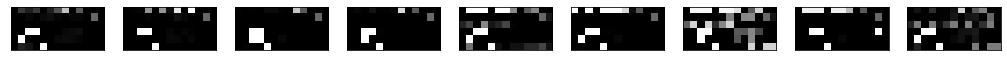

In [ ]:
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(1,10):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(train_gray[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

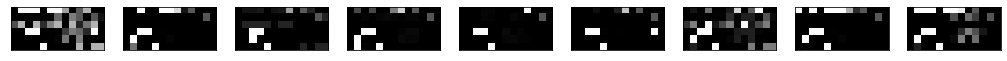

In [ ]:
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(1,10):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_gray[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

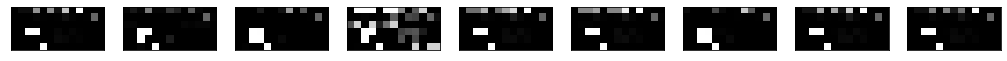

In [ ]:
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(1,10):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(val_gray[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [ ]:
#hyper-params
batch_size =9500 # increasing batch size with more gpu added
input_dim = X_train.shape[1]
num_class = 15                   # 15 intrusion classes, including benign traffic class
num_epochs = 6
learning_rates = 1e-4
regularizations = 1e-3
optim = tf.keras.optimizers.Adam(lr=learning_rates, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

print(input_dim)
print(num_class)

78
15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model2d_g = Sequential()
model2d_g.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(6,13,1)))
model2d_g.add(Conv2D(64, kernel_size=(3 ,3), padding='same',  activation='relu'))
model2d_g.add(Conv2D(128, kernel_size=(3,3), padding='same',  activation='relu'))
model2d_g.add(Flatten())
model2d_g.add(Dropout(0.2))
model2d_g.add(Dense(512))
model2d_g.add(Dense(num_class, activation='softmax'))
 
model2d_g.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 6, 13, 32)         320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 13, 64)         18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 13, 128)        73856     
_________________________________________________________________
flatten (Flatten)            (None, 9984)              0         
_________________________________________________________________
dropout (Dropout)            (None, 9984)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               5112320   
_________________________________________________________________
dense_1 (Dense)              (None, 15)                7

In [ ]:
from keras.optimizers import Nadam, Adam, RMSprop
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
import keras
import time
time_start = time.time()

reduce_lr = keras.callbacks.ReduceLROnPlateau(moniter='val_loss',
                                              factor=0.1,
                                              patience=10)
nadam = Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.0001)
model2d_g.compile(loss = "categorical_crossentropy",optimizer = "nadam", metrics = METRICS)
#model2d_g.compile(loss='categorical_crossentropy',
#              optimizer= RMSprop(lr=0.001), #,SGD(lr=0.01), #
#              metrics=METRICS)

#model2d_g.compile(
#      optimizer= Adam(lr=1e-4),
#      loss=tf.keras.losses.BinaryCrossentropy(),
#      loss='categorical_crossentropy',
#      metrics=METRICS)

history = model2d_g.fit(X_train_gray, y_train, 
                    epochs=6, 
                    batch_size=batch_size, 
                    verbose=2,
                    validation_data=(X_val_gray, y_val),
                    callbacks=[reduce_lr])
time_end = time.time()
train_time = time_end - time_start
print("train_time:",train_time)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/6
93/93 - 28s - loss: 0.3588 - tp: 754421.0000 - fp: 75118.0000 - tn: 12239128.0000 - fn: 125168.0000 - accuracy: 0.9848 - precision: 0.9094 - recall: 0.8577 - auc: 0.9933 - val_loss: 0.1555 - val_tp: 176118.0000 - val_fp: 9789.0000 - val_tn: 2628987.0000 - val_fn: 12366.0000 - val_accuracy: 0.9922 - val_precision: 0.9473 - val_recall: 0.9344 - val_auc: 0.9988
Epoch 2/6
93/93 - 7s - loss: 0.1201 - tp: 839355.0000 - fp: 33265.0000 - tn: 12280981.0000 - fn: 40234.0000 - accuracy: 0.9944 - precision: 0.9619 - recall: 0.9543 - auc: 0.9990 - val_loss: 0.0928 - val_tp: 180885.0000 - val_fp: 6494.0000 - val_tn: 2632282.0000 - val_fn: 7599.0000 - val_accuracy: 0.9950 - val_precision: 0.9653 - val_recall: 0.9597 - val_auc: 0.9995
Epoch 3/6
93/93 - 8s - loss: 0.0862 - tp: 850598.0000 - fp: 25405.0000 - tn: 12288841.0000 - fn: 28991.0000 - accuracy: 0.9959 - precision: 0.9710 - recall: 0.9670 - auc: 0.9994 - val_loss: 0.0826 - val_tp: 182341.0000 - val_fp: 5430.0000 - val_tn: 2633346.0000

## Get the metrics

In [ ]:
# evaluate model
accuracy = model2d_g.evaluate(X_test_gray, y_test, batch_size=batch_size, verbose=1)

20/20 [==============================] - 1s 49ms/step - loss: 0.0629 - tp: 183591.0000 - fp: 4661.0000 - tn: 2634101.0000 - fn: 4892.0000 - accuracy: 0.9966 - precision: 0.9752 - recall: 0.9740 - auc: 0.9998


In [ ]:
y_pred=model2d_g.predict(X_test_gray)

In [ ]:
display_metrics(y_test_ada, np.argmax(y_pred, axis = 1), labels_d)


Accuracy: 0.97

Micro Precision: 0.97
Micro Recall: 0.97
Micro F1-score: 0.97

Macro Precision: 0.72
Macro Recall: 0.71


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro F1-score: 0.71

Weighted Precision: 0.98
Weighted Recall: 0.97
Weighted F1-score: 0.97

Classification Report



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       1.00      0.98      0.99    105019
                       Bot       0.79      0.86      0.82       280
                      DDoS       0.90      0.97      0.93     19271
             DoS GoldenEye       0.99      0.96      0.98      1542
                  DoS Hulk       0.98      0.94      0.96     34547
          DoS Slowhttptest       0.95      0.99      0.97       828
             DoS slowloris       0.94      0.93      0.93       834
               FTP-Patator       0.98      0.99      0.99      1178
                Heartbleed       0.00      0.00      0.00         2
              Infiltration       0.00      0.00      0.00         1
                  PortScan       0.94      1.00      0.97     23846
               SSH-Patator       0.96      0.96      0.96       826
  Web Attack � Brute Force       0.67      0.67      0.67       209
Web Attack � Sql Injection       0.00      0.00

### Save the model

In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 16.4MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491619 sha256=39d1ff900fd05caf1cb2a8196d2d633c3de007699ce086163387d66f896d6d2d
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


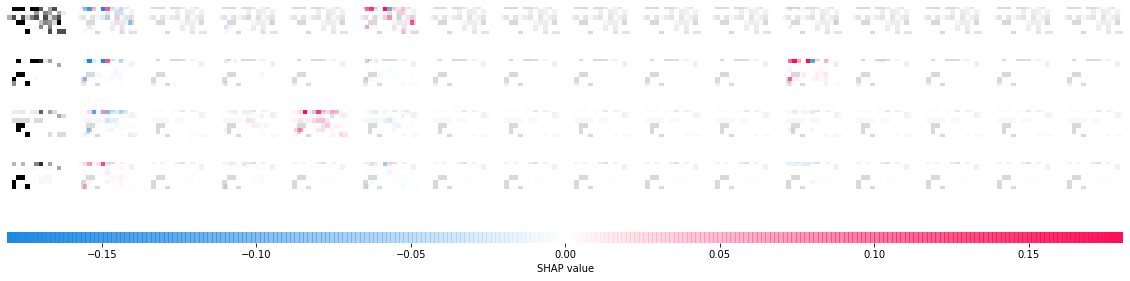

In [ ]:
import shap


# select a set of background examples to take an expectation over
background = X_train_gray[np.random.choice(X_train_gray.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model2d_g, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(X_test_gray[1:5])

# plot the feature attributions
shap.image_plot(shap_values, -X_test_gray[1:5])